In [1]:
import numpy as np
import stim
from matplotlib import pyplot as plt

## Basic circuit

In [2]:
circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
circuit.append("M", [0, 1])

circuit.diagram()

q0: -H-@-M:rec[0]-
       |
q1: ---X-M:rec[1]-

In [3]:
sampler = circuit.compile_sampler()
print(sampler.sample(shots=10))

[[False False]
 [ True  True]
 [False False]
 [False False]
 [ True  True]
 [ True  True]
 [False False]
 [ True  True]
 [False False]
 [ True  True]]


## Detector annotations

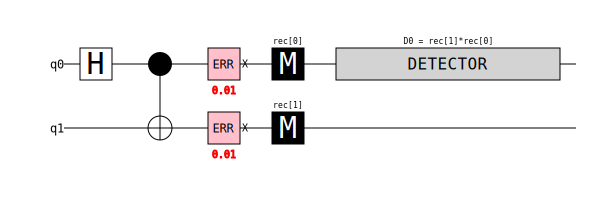

In [4]:
error_p = 0.01
circuit = stim.Circuit()
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])
circuit.append("X_ERROR", [0, 1], error_p)
circuit.append("M", [0, 1])
circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)])
circuit.diagram("timeline-svg")

In [5]:
shots = 10**6

sampler = circuit.compile_sampler()
p_ij = sampler.sample(shots)
print(np.unique(p_ij, return_counts=True, axis=0))

sampler = circuit.compile_detector_sampler()
p_ij = sampler.sample(shots)
print(np.unique(p_ij, return_counts=True))
print(np.sum(p_ij) / shots, 2 * error_p * (1 - error_p))

(array([[False, False],
       [False,  True],
       [ True, False],
       [ True,  True]]), array([490367,   9843,   9835, 489955]))
(array([False,  True]), array([980292,  19708]))
0.019708 0.0198


## Repetition code

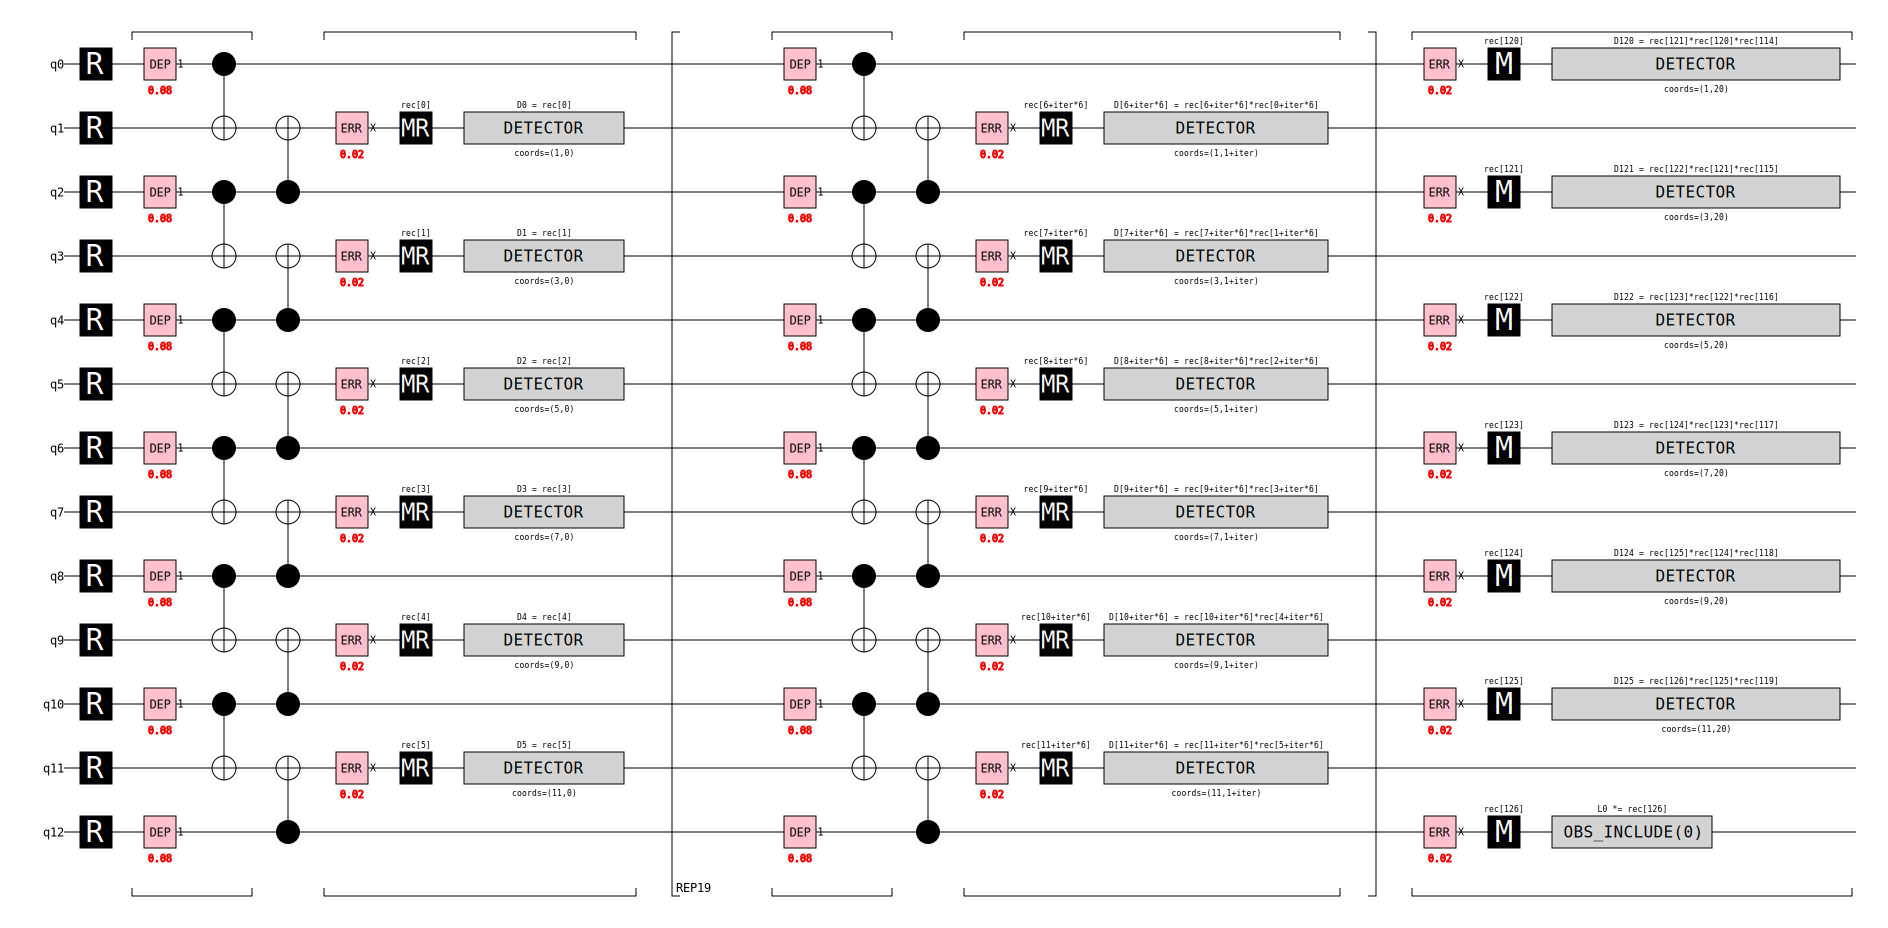

In [6]:
distance = 7
rounds = 20
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    distance=distance,
    rounds=rounds,
    before_round_data_depolarization=0.08,
    before_measure_flip_probability=0.02,
)
circuit.diagram("timeline-svg")

### DEF

(1000000, 126)
(21, 6)


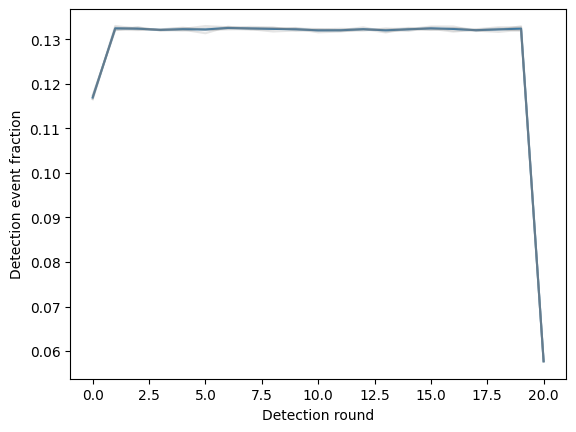

In [7]:
shots = 10**6
detector_sampler = circuit.compile_detector_sampler()
detector_sample = detector_sampler.sample(shots)
print(detector_sample.shape)

res: np.ndarray = detector_sample.mean(axis=0).reshape((rounds + 1, distance - 1))
print(res.shape)

plt.plot(res.mean(axis=1))
plt.plot(res, "gray", alpha=0.2)
plt.xlabel("Detection round")
plt.ylabel("Detection event fraction")
plt.show()

### Correlation matrix

In [8]:
xi = detector_sample.mean(axis=0)
print(xi.shape)

(126,)


In [9]:
# Space-first
def calc_p_ij(sample: np.ndarray, approximate: bool = True) -> np.ndarray:
    xi = sample.mean(axis=0)
    xi_xj = np.einsum('ij,ik->ijk', sample, sample).mean(axis=0)
    if approximate:
        p_ij = (xi_xj - np.outer(xi, xi)) / np.outer(1 - 2 * xi, 1 - 2 * xi)
    else:
        ones = np.ones_like(xi)
        a = 4 * (xi_xj - np.outer(xi, xi))
        b = 1 - 2 * np.outer(xi, ones) - 2 * np.outer(np.ones_like(xi), xi) + 4 * xi_xj
        p_ij = 0.5 - 0.5 * np.sqrt(1 - a / b)
    np.fill_diagonal(p_ij, 0)
    return p_ij

p_ij = calc_p_ij(detector_sample, approximate=False)
print(p_ij.shape)

(126, 126)


In [10]:
# Time-first
p_ij_t = p_ij.reshape((rounds + 1, distance - 1, rounds + 1, distance - 1)).transpose(1, 0, 3, 2)
p_ij_t = p_ij_t.reshape((rounds + 1) * (distance - 1), (rounds + 1) * (distance - 1))
print(p_ij_t.shape)

(126, 126)


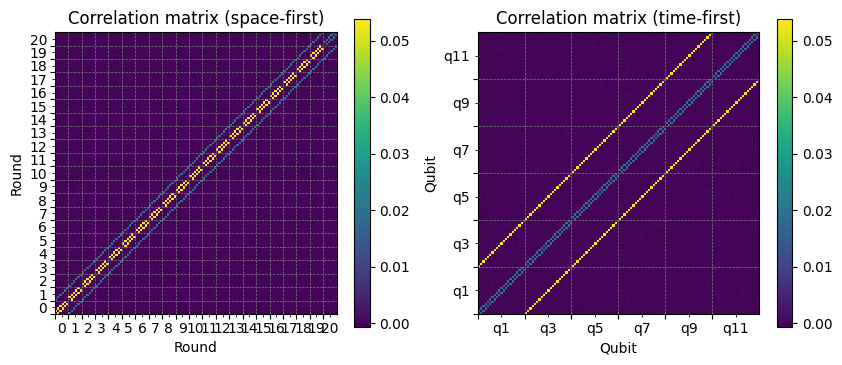

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# First subplot
im1 = axs[0].imshow(p_ij, interpolation="none")
fig.colorbar(im1, ax=axs[0])
axs[0].set_title("Correlation matrix (space-first)")
axs[0].set_xlabel("Round")
axs[0].set_ylabel("Round")
axs[0].invert_yaxis()

ticks = np.arange(rounds + 1) * (distance - 1) - 0.5
labels = range(rounds + 1)

axs[0].set_xticks(ticks, [])
axs[0].set_xticks(ticks + (distance - 1) / 2, labels, minor=True)
axs[0].set_yticks(ticks, [])
axs[0].set_yticks(ticks + (distance - 1) / 2, labels, minor=True)
axs[0].grid(which="major", color="gray", linestyle="--", linewidth=0.5)

# Second subplot
im2 = axs[1].imshow(p_ij_t, interpolation="none")
fig.colorbar(im2, ax=axs[1])
axs[1].set_title("Correlation matrix (time-first)")
axs[1].set_xlabel("Qubit")
axs[1].set_ylabel("Qubit")
axs[1].invert_yaxis()

ticks = np.arange(distance - 1) * (rounds + 1) - 0.5
labels = [f"q{i * 2 + 1}" for i in range(distance - 1)]

axs[1].set_xticks(ticks, [])
axs[1].set_xticks(ticks + (rounds + 1) / 2, labels, minor=True)
axs[1].set_yticks(ticks, [])
axs[1].set_yticks(ticks + (rounds + 1) / 2, labels, minor=True)
axs[1].grid(which="major", color="gray", linestyle="--", linewidth=0.5)

plt.show()

### S and T errors

In [ ]:
# Boundary error probabilities
def g(p, q):
    return p + q - 2 * p * q

def calc_p(*xs):
    if len(xs) == 2:
        return g(*xs)
    return g(xs[0], calc_p(*xs[1:]))

# Top boundary
p_i_s1 = np.concatenate([
    [calc_p(p_ij_t[0, rounds + 1], p_ij_t[0, 1])],
    [calc_p(p_ij_t[j, j + rounds + 1], p_ij_t[j, j - 1], p_ij_t[j, j + 1]) for j in range(1, rounds)],
    [calc_p(p_ij_t[rounds, 2 * rounds + 1], p_ij_t[rounds, rounds - 1])],
])
p_i_b1 = (xi[0 :: distance - 1] - p_i_s1) / (1 - 2 * p_i_s1)

# Bottom boundary
k = (distance - 2) * (rounds + 1)
p_i_s2 = np.concatenate([
    [calc_p(p_ij_t[k, (distance - 3) * (rounds + 1)], p_ij_t[k, k + 1])],
    [
        calc_p(p_ij_t[k + j, k + j - rounds - 1], p_ij_t[k + j, k + j - 1], p_ij_t[k + j, k + j + 1])
        for j in range(1, rounds)
    ],
    [calc_p(p_ij_t[k + rounds, k - 1], p_ij_t[k + rounds, k + rounds - 1])],
])
p_i_b2 = (xi[distance - 2 :: distance - 1] - p_i_s2) / (1 - 2 * p_i_s2)

print(p_i_b1)
print(p_i_b2)

[0.05345936 0.05325099 0.05325285 0.05359661 0.05411053 0.05291243
 0.0532368  0.05372361 0.0537989  0.05311382 0.05311508 0.05301804
 0.05401947 0.05325449 0.05363155 0.05347243 0.05288658 0.05307614
 0.05351579 0.0537864  0.01986996]
[0.05315927 0.05362473 0.05423499 0.05322468 0.05336031 0.05279509
 0.05368384 0.05319484 0.05322514 0.0533817  0.05387597 0.05361814
 0.05341964 0.05342176 0.05335216 0.05361003 0.05357192 0.05360048
 0.05382889 0.05335802 0.02013675]


In [13]:
t_edges = np.array([
    i[:-1] for i in np.split(np.append(p_ij_t.diagonal(1), 0), distance - 1)
])
print(t_edges.shape)

s_edges = np.array(np.split(p_ij_t.diagonal(rounds + 1), distance - 2))
s_edges = np.vstack((p_i_b1, s_edges, p_i_b2))
print(s_edges.shape)

(6, 20)
(7, 21)


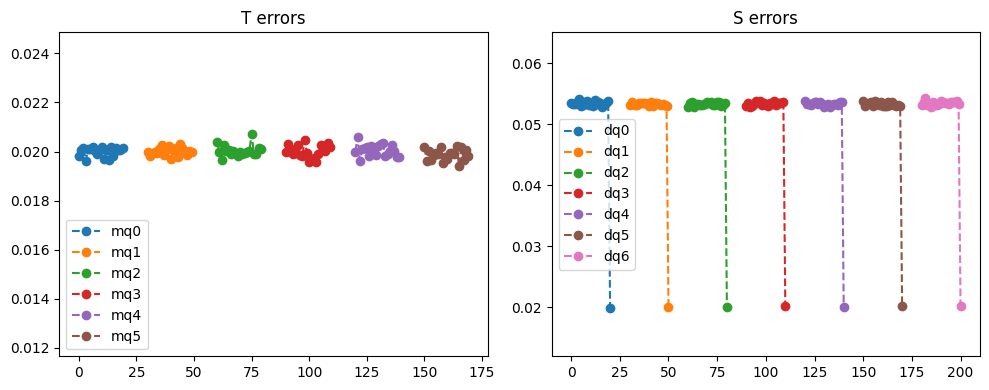

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot T errors
for i, edge in enumerate(t_edges):
    axs[0].plot(np.arange(len(edge)) + i * (rounds + 10), edge, "o--", label=f"mq{i}")
axs[0].set_ylim(t_edges.min() * 0.6, t_edges.max() * 1.2)
axs[0].legend()
axs[0].set_title("T errors")

# Plot S errors
for i, edge in enumerate(s_edges):
    axs[1].plot(np.arange(len(edge)) + i * (rounds + 10), edge, 'o--', label=f'dq{i}')
axs[1].set_ylim(s_edges.min() * 0.6, s_edges.max() * 1.2)
axs[1].legend()
axs[1].set_title("S errors")

plt.tight_layout()
plt.show()